### List of goals
- Goal 1: clean the signal from artifacts and plan the best strategy for analysis: implement any code that is needed to further clean the signal and think on the best way to achieve goal 2
- Goal 2: decode glucose information from VN recordings: e.g. right before eating, glucose change..

In [1]:
import IPython
# IPython.Application.instance().kernel.do_shutdown(True)

# %matplotlib notebook 
#import mpld3
#mpld3.enable_notebook()

%matplotlib widget

import os
import sys
import json
import time
import datetime
import pycwt
import statistics
import random
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import sklearn as sk
import tkinter as tk
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import decomposition
from sklearn.decomposition import PCA
from tkinter import *
from tkinter import ttk
from sklearn import preprocessing
from datetime import date
import matplotlib.dates as mdates

from neurodsp.rhythm import sliding_window_matching
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.rhythm import plot_swm_pattern
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import set_random_seed, create_times
# Import listed chormap
from matplotlib.colors import ListedColormap
import matplotlib.dates as md
from matplotlib import colors as mcolors
# Scipy
from scipy import signal
from scipy import ndimage
# TKinter for selecting files
from tkinter import Tk     # from tkinter import Tk for Python 3.x
from tkinter.filedialog import askdirectory

# Add my module to python path
sys.path.append("../")

# Own libraries
from Neurogram_short import * # Recording, MyWavelet, MyWaveforms
from additional_functions import * 

os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Load data

In [2]:
Tk().withdraw()  # keep the root window from appearing
dir_name = ('../datasets/')

path = '../datasets/rat5/day1' # Port A
# path = '../datasets/rat7&8/day2' 
map_path = '../datasets/map_linear.csv'

# When using port A: channels=range(0,32,1) by default port B:range(32,64,1)
# Start and dur in samples
# feinstein: channels=[0]
time_start = time.time()
load_from_file=True     # Keep it always to true
downsample = 2          # Only when loading from raw - no need to use it
start= 0                   
dur = None               

port = 'Port A'  # Select port A or B for different recordings
record = Recording.open_record(path, start=start, dur=dur, 
                               load_from_file=load_from_file, 
                               load_multiple_files=True,
                               downsample=downsample,
                               port=port,  # Select recording port
                               map_path=map_path,
                               verbose=0)

# Create directory to save figures
if not os.path.exists('%s/figures/' %(path)):
    os.makedirs('%s/figures/' %(path))
print("Time elapsed: {} seconds".format(time.time()-time_start)) 

#sys.exit()

../datasets/rat5/day1
Loading from file C:/Users/airbl/OneDrive - University of Cambridge/Documents/Cambridge Work IIB/IIB Project/Code/code_Peter/datasets/rat5/day1/recording_230718_111958_133858_Port B.pkl
0
stop: 83506752
10000.0
['5', '8', '13']
                                      ch_5       ch_8       ch_13    seconds  \
time                                                                           
1970-01-01 00:00:00.000000000  1065.479980   7.215000  185.639999     0.0000   
1970-01-01 00:00:00.000100000  1102.724976   7.020000  184.860001     0.0001   
1970-01-01 00:00:00.000200000  1154.204956  27.105000  218.789993     0.0002   
1970-01-01 00:00:00.000300000  1236.689941  56.160000  276.315002     0.0003   
1970-01-01 00:00:00.000400000  1271.594971  73.709999  318.825012     0.0004   
...                                    ...        ...         ...        ...   
1970-01-01 02:19:10.674700000    14.625000  16.184999  -13.065000  8350.6747   
1970-01-01 02:19:10.674800000 

### Prepare 'channels' variable:

In [7]:
channels = []
for col in record.recording.columns:
    if col.startswith('ch_'):
        # self.recording[col] = self.recording[col].astype('float32')
        channels.append(col.replace('ch_', ''))

### Plot raw signals

In [ ]:
# start_time = None
# end_time = None
start_time = "00000"
end_time = "01000"
ylim = None
record.plot_raw_signals(start_time=start_time, end_time=end_time, ylim=ylim)
# record.plot_raw_signals(ylim=(-500,500))

# Setting up:

In [3]:
# Get current time for saving (avoid overwriting)
now = datetime.datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

In [4]:
## Configuration

In [5]:
# Do not change
options_filter = [
    "None", 
    "butter", 
    "fir"]                # Binomial Weighted Average Filter

options_detection = [
    "get_spikes_threshCrossing", # Ojo: get_spikes_threshCrossing needs detects also cardiac 
                                     # spikes, so use cardiac_window. This method is slower
    "get_spikes_method",         # Python implemented get_spikes() method. Faster
    "so_cfar"]                    # Smallest of constant false-alarm rate filter

options_threshold = [
    "positive",
    "negative", 
    "both_thresh"]

In [8]:
# Configure
config_text = []
record.apply_filter = options_filter[1]    
record.detect_method = options_detection[1]   # leave it to butter (option 1)                                 
record.thresh_type = options_threshold[0]     # do not use it for now
# Select channel position/number in intan (not channel number in device)

# record.channels = [5,8,13]  # Select the channels to use. E.g. 5,8,13 for the recording you have now. Include 'all' to select all the channels available
record.channels = channels

record.path = path  
config_text = ['Load_from_file %s' %load_from_file, 'Filter: %s'%record.apply_filter, 'Detection: %s'%record.detect_method, 'Threhold type: %s'%record.thresh_type, 'Channels: %s' %record.channels, 'Downsampling: %s' %downsample]
config_text.append('Port %s' %(port))
config_text.append('Start %s, Dur: %s' %(start,dur))
config_text.append('Channels: %s' %record.channels)
# Ramarkable timestamps (in sec) 

group = '1'

print('SELECTED GENERAL CONFIGURATION:')
print('Filter: %s'%record.apply_filter)
print('Detection: %s'%record.detect_method)
print('Threhold type: %s'%record.thresh_type)
print('Channels: %s' %record.channels) 
print('-------------------------------------')

record.select_channels(record.channels) # keep_ch_loc=True if we want to display following the map. Otherwise follow the order provided by selected channels.
print('map_array: %s' %record.map_array)
print('ch_loc: %s' %record.ch_loc)
print('filter_ch %s' %record.filter_ch)
print('column_ch %s' %record.column_ch)

SELECTED GENERAL CONFIGURATION:
Filter: butter
Detection: get_spikes_method
Threhold type: positive
Channels: ['5', '8', '13']
-------------------------------------
map_array: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
ch_loc: [5, 8, 13]
filter_ch ['ch_5', 'ch_8', 'ch_13']
column_ch ['5', '8', '13']


#### Select visualization options:  

In [9]:
# Configure
record.num_rows = 2 #int(round(len(record.filter_ch)/2)) # round(n_components/2) 
record.num_columns = 1 #int(len(record.filter_ch)-round(len(record.filter_ch)/2))+1 
plot_ch = int(record.map_array[record.ch_loc[0]])                                                
print(plot_ch)
print(record.num_rows)
print(record.num_columns)
save_figure = True

5
2
1


##### Gain

In [10]:
gain = 1
config_text.append('Gain: %s' %(gain))

##### Maximum bpm

In [11]:
bpm = 300
record.set_bpm(bpm) # General max bpm in rat HR. Current neurograms at 180bpm
config_text.append('BPM: %s' %(bpm))

#### Final initializations (No need to change)  

In [12]:
# Initialize dataframe for results 
#----------------------------------------------------
record.rolling_metrics = pd.DataFrame()
record.summary = pd.DataFrame(columns=['Max_spike_rate', 'Min_spike_rate',
                                'Max_amplitude_sum', 'Min_amplitude_sum'])
record.summary.index.name = 'channel'
record.sig2noise = [] #To save the snr for each channel

# Intialize dataframes for wavelet decomposition
#---------------------------------------------------
neural_wvl = pd.DataFrame(columns=record.filter_ch)
neural_wvl_denoised = pd.DataFrame(columns=record.filter_ch)
other_wvl = pd.DataFrame(columns=record.filter_ch)
substraction_wvl = pd.DataFrame(columns=record.filter_ch)

## Below cell only works after applying filter: 

In [ ]:
text_label = 'Filtered'
text = 'Channels after %s filtering'%record.apply_filter
record.plot_freq_content(record.filtered, int(plot_ch), nperseg=512, max_freq=4000, ylim=[-100, 100], dtformat='%H:%M:%S',
                         figsize=(10, 10), savefigpath='%s/figures/%s_ch%s_butter_filtering-%s.png' %(record.path, port, plot_ch, current_time))

### Plot raw signal

In [ ]:
record.plot_freq_content(record.original,int(plot_ch), nperseg=512, max_freq=4000, ylim=[-500, 500], dtformat='%H:%M:%S',
                         figsize=(10, 10), savefigpath='%s/figures/%s_ch%s_original-%s.png' %(record.path, port, plot_ch, current_time), 
                         show=True) 

### Channel referencing

In [ ]:
ref_ch_name = 'mean' #'mean'
if ref_ch_name == 'mean':
    # all_ch_list = [col for col in channels if col.startswith('ch_')] 
    all_ch_list = [col for col in record.recording.columns if col.startswith('ch_')] 
    ref_ch = record.original[all_ch_list].mean(axis=1)
else:
    ref_ch = record.original['ch_%s'%ref_ch_name]  
record.referenced = record.original[record.filter_ch].sub(ref_ch, axis=0)
record.referenced['seconds'] = record.original['seconds']
record.recording=record.referenced
record.recording.name = 'referenced'
config_text.append('ref_ch: %s' % ref_ch_name)


In [ ]:
record.plot_freq_content(record.referenced,int(plot_ch), nperseg=512, max_freq=4000, ylim=[-750,750], dtformat='%H:%M:%S',figsize=(10, 10),
                         savefigpath='%s/figures/%s_ch%s_ref%s-%s.png' %(record.path, port, plot_ch, ref_ch_name, current_time),
                         show=True) 
    

### Filtering

#### Bandwidth filter

In [13]:
# Configure - change as needed
filt_config = {
    'W': [400, 4000],  # (max needs to be <fs/2 per Nyquist)
    'None': {},
    'butter': {
            'N': 9,                # The order of the filter
            'btype': 'bandpass', #'bandpass', #'hp'  #'lowpass'     # The type of filter.
    },      
    'fir': {
            'n': 4,
    },
    'notch': {
            'quality_factor': 30,
    },
}

filt_config['butter']['Wn'] = filt_config['W']
filt_config['butter']['fs'] = record.fs

config_text.append('filt_config: %s' %json.dumps(filt_config))

##### Apply filter

In [14]:
# Configure
time_start = time.time()
signal2filter = record.recording    # The neural data imported via pkl file 
config_text.append('signal2filter: %s' %signal2filter.name)
record.filter(signal2filter, record.apply_filter, **filt_config[record.apply_filter])
# Change from float64 to float 16
record.filtered = convertDfType(record.filtered, typeFloat='float32')
#print(record.filtered.dtypes)
print("Time elapsed: {} seconds".format(time.time()-time_start))

{'N': 9, 'btype': 'bandpass', 'Wn': [400, 4000], 'fs': 10000.0}
Time elapsed: 13.855777740478516 seconds


##### Plot filtered signal

#### Notch filtering: check if needed

In [ ]:
time_start = time.time()
freq_notch =  range(450, 2000, 100) #change as needed
for n in freq_notch:
    filt_config['notch']['notch_freq'] = n
    record.filter(record.filtered, 'notch', **filt_config['notch'])
print("Time elapsed: {} seconds".format(time.time()-time_start))
config_text.append('notch_filtered:applied')
# Change from float64 to float 16
record.filtered = convertDfType(record.filtered, typeFloat='float32')

record.recording=record.filtered
record.recording.name = 'filtered'

In [ ]:
text_label = 'Filtered'
text = 'Channels after %s filtering'%'notch'

record.plot_freq_content(record.filtered, int(plot_ch), ylim=[-100, 100], nperseg=512, max_freq=4000, dtformat='%H:%M:%S',
                         figsize=(10, 10), savefigpath='%s/figures/%s_ch%s_allfilt-%s.png' %(record.path, port,plot_ch, current_time), show=True) 

# Testing MA discarding algorithm with filtered dataset

In [15]:
from tqdm import tqdm

In [16]:
# std_coeff=1
figsize=None
ylim=None

"""
Method: Intuitive, calculates the standard deviation of each channel after filtering, and then discard anything
        above a certain threshold based on the standard deviation
Currently plots the data for each channel after discarding the corrupted windows

Using Port B currently
"""


channels = []
for ch in record.channels:
    channels.append('ch_' + str(ch))

if figsize is None:
    figsize = (10, 10*len(channels))
if ylim is not None:
    ylim = ylim

# fig, ax = plt.subplots(len(channels), 1, figsize=figsize)
# 
# modified_df = record.filtered.copy()
# for i in range(len(channels)):
#     windows_to_keep = []
#     std = record.filtered[channels[i]].std()
#     mean = record.filtered[channels[i]].mean()
#     for idx in range(record.length//Recording.window_length + 1):
#         window_mean = record.filtered[record.filtered["window"] == idx][channels[i]].mean()
#         if abs(window_mean - mean) < std * std_coeff:
#             windows_to_keep.append(idx)
#     values = modified_df[modified_df["window"].isin(windows_to_keep)]
#     x_range = [i for i in range(len(values))]
#     ax[i].plot(x_range, values, linewidth=0.5, zorder=0)
#     ax[i].set_title(f"Channel {channels[i]} after discarding MA corrupted windows")
#     ax[i].set_xlabel('Sample Index')
#     ax[i].set_ylabel('Voltage [uV]')
#     if ylim is not None:
#         ax[i].set_ylim(ylim)

modified_df = record.filtered.copy()[['ch_5', 'window']]

print("SUCCESS")

max_window_mean = 0
max_window_idx = 0

def abs_convert(x):
    return abs(x)

modified_df = modified_df[['ch_5', 'window']].apply(abs_convert)

SUCCESS


In [ ]:
modified_df.head

In [ ]:
modified_df['ch_5'].std()

In [ ]:
modified_df['window'][0]

In [62]:
std_coeff=1

windows_to_keep = set()
std = record.filtered['ch_5'].std()
mean = record.filtered['ch_5'].mean()
for idx in tqdm(range(record.length//Recording.window_length + 1)):
    # window_mean = record.filtered[record.filtered["window"] == idx]['ch_5'].mean()
    window_mean = modified_df[modified_df['window'] == idx]['ch_5'].mean()
    # print(window_mean)
    if abs(window_mean) > max_window_mean:
        max_window_mean = abs(window_mean)
        max_window_idx = idx
    if abs(window_mean - mean) < std * std_coeff:
        windows_to_keep.add(idx)

100%|██████████| 8351/8351 [10:52<00:00, 12.79it/s] 


In [58]:
print(max_window_mean)
print(max_window_idx)

27.423622131347656
1345


In [59]:
len(windows_to_keep)

696

In [60]:
removed_windows = []
# for i in range(int(modified_df['window'][-1]) + 1):
for i in range(record.length//Recording.window_length + 1):
    if i not in windows_to_keep:
        removed_windows.append(i)

In [61]:
removed_windows

[]

In [105]:
values = modified_df[modified_df["window"].isin(windows_to_keep)]['ch_5'][100:6000000]

In [106]:
values = values.tolist()

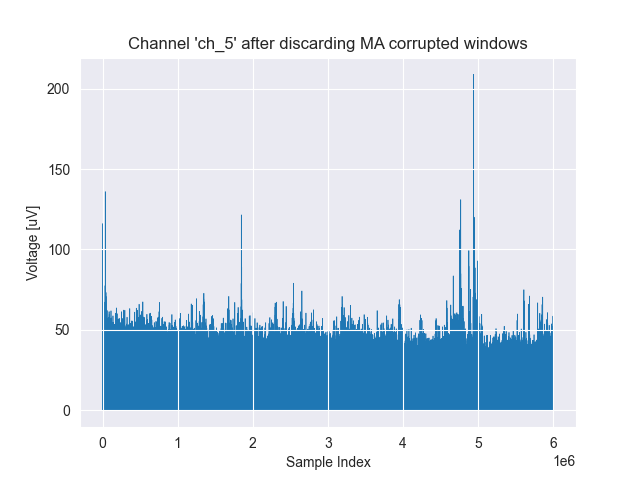

In [107]:
x_range = [i for i in range(len(values))]
fig, ax = plt.subplots()
ax.plot(x_range, values, linewidth=0.5, zorder=0)
plt.title("Channel 'ch_5' after discarding MA corrupted windows")
plt.xlabel('Sample Index')
plt.ylabel('Voltage [uV]')
if ylim is not None:
    plt.ylim(ylim)
plt.show()

TypeError: matplotlib.font_manager.FontProperties() argument after ** must be a mapping, not int

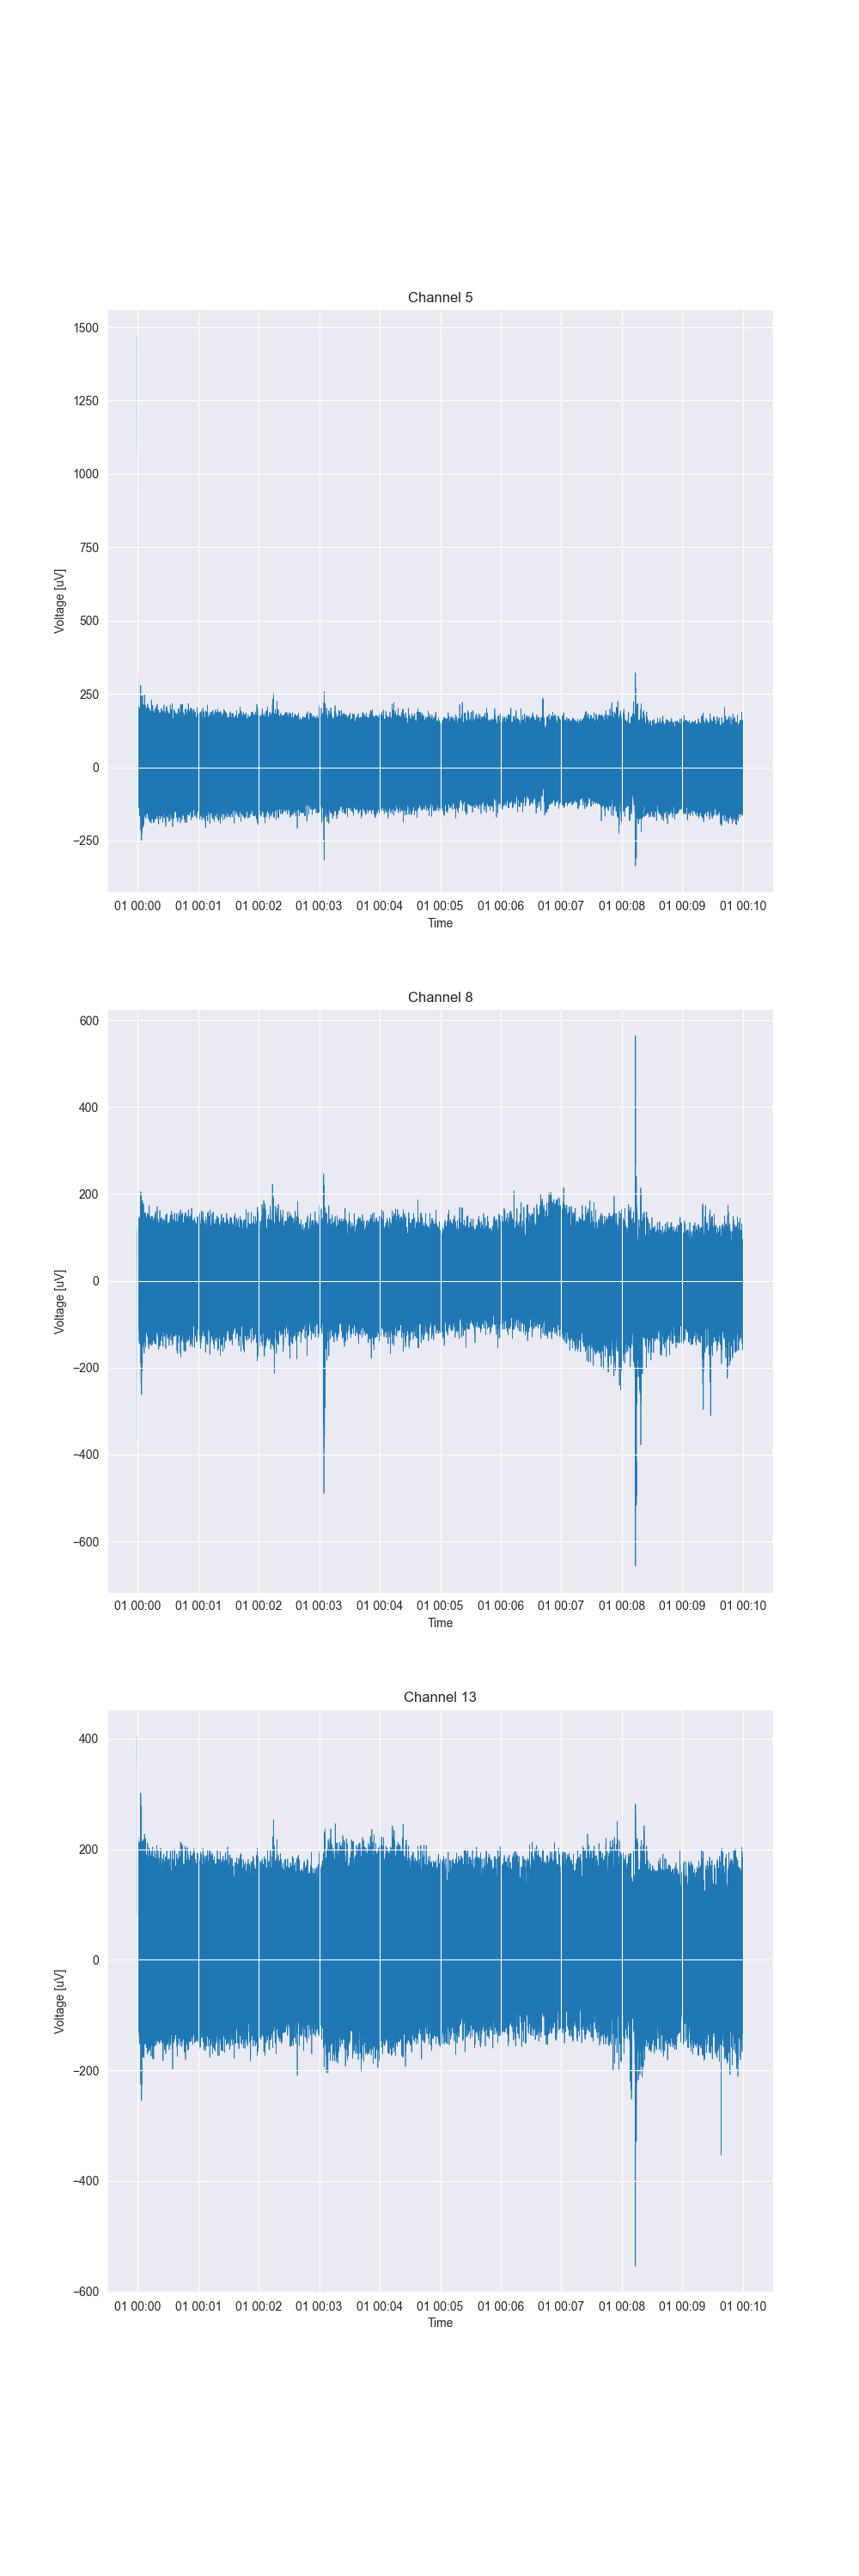

In [21]:
# start_time = None
# end_time = None
start_time = "00000"
end_time = "01000"
ylim = None
record.plot_raw_signals(start_time=start_time, end_time=end_time, ylim=ylim)
# record.plot_raw_signals(ylim=(-500,500))

In [44]:
# Plot ch_5 with locations of discarded windows marked out

def mark_MA(channels=None, start_time=None, end_time=None, figsize=None, ylim=None):
    """
    start_time, end_time : [string] in mmmss format e.g. 2 hr 10 min 30 sec -> 13030(xxxx)
                           ....(xxxx) optional - numbers behind the decimal point to specify fractions of a second
    """
    if channels is None:
        channels = []
        for col in record.recording.columns:
            if col.startswith('ch_'):
                # self.recording[col] = self.recording[col].astype('float32')
                # channels.append(col.replace('ch_', ''))
                channels.append(col[3:])

    if start_time is None:
        start_index = 0
    else:
        start_index = 0
        start_index += int(start_time[:3]) * 600000
        start_index += int(start_time[3:5]) * 10000
        if len(start_time) == 9:
            start_index += int(start_time[5:])

    if end_time is None:
        end_index = len(record.recording.index)
    else:
        end_index = 0
        end_index += int(end_time[:3]) * 600000
        end_index += int(end_time[3:5]) * 10000
        if len(end_time) == 9:
            end_index += int(end_time[5:])

    if figsize is None:
        figsize = (10, 10)
    if ylim is not None:
        ylim = ylim

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    x_range = [i for i in range(start_index, end_index)]

    signal = record.recording['ch_%s' % channels[0]][x_range]
    ax.plot(record.recording.index[x_range], signal, linewidth=0.5, zorder=0)
    # ax[i].xaxis.set_major_formatter(FuncFormatter(time_formatter))
    ax.set_title("Channel %s" % channels[0])
    ax.set_xlabel('Time')
    ax.set_ylabel('Voltage [uV]')
    
    # label windows marked as MA
    for w in removed_windows:
        if w*Recording.window_length < 18000000:
            ax.axvline(x=record.recording.index[w*Recording.window_length], color="r", linewidth=0.02)
    if ylim is not None:
        ax.set_ylim(ylim)
    fig.suptitle('Sampling Frequency: {}Hz'.format(record.fs), fontsize=16)

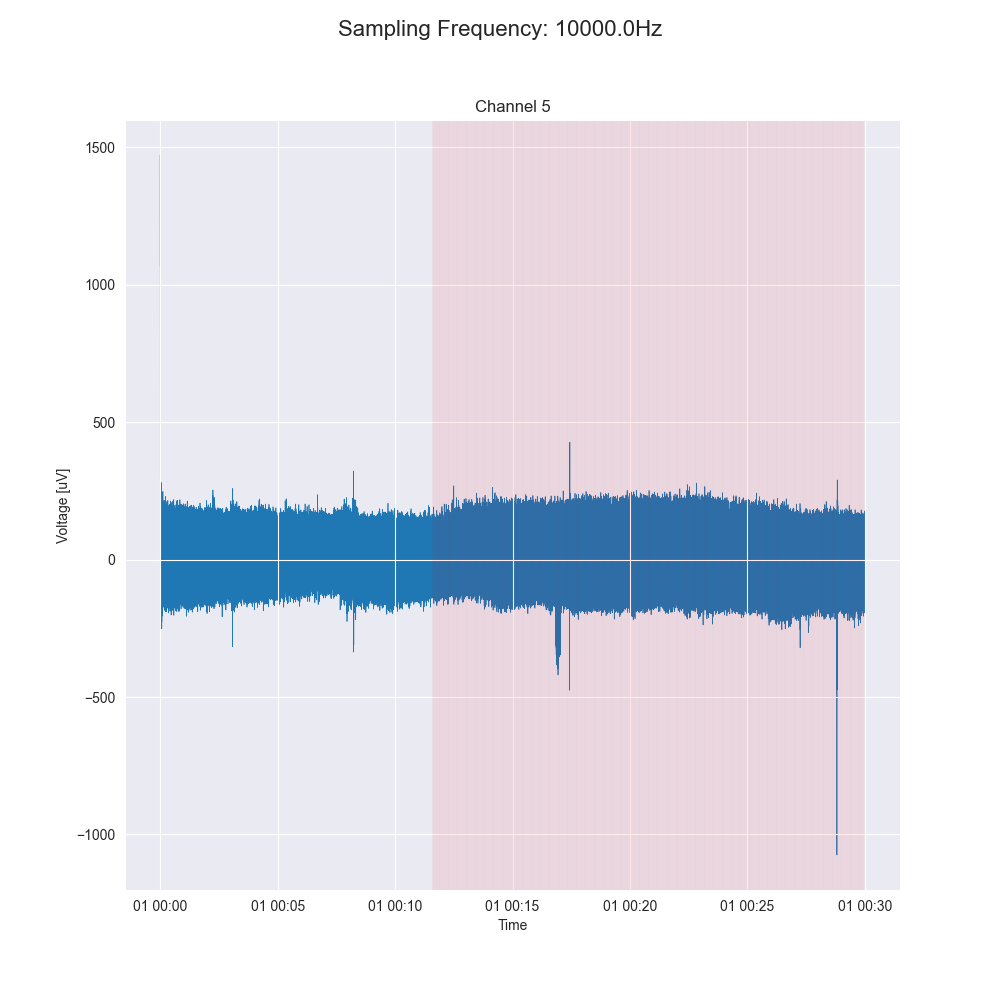

In [45]:
mark_MA(start_time="00000", end_time="03000")

In [ ]:
print(1)

### NOISE: Envelope derivative operator (EDO)

In [ ]:
# Re-importing additional_functions after having made changes to it

import importlib
import additional_functions
from additional_functions import *
importlib.reload(additional_functions)

In [ ]:
noise_edo=pd.DataFrame()

for ch in record.filter_ch:
    x = record.recording[ch].to_numpy() 
    # Apply EDO filter
    x_e = gen_edo(x)
    # Store in DF to be loaded in signal analysis
    noise_edo[ch] = x_e
noise_edo['seconds'] = np.asarray(record.recording['seconds'])
noise_edo.index = pd.DatetimeIndex(noise_edo.seconds * 1e9)
noise_edo.index.name = 'time'
noise_edo.name = 'noise_edo'

config_text.append('signal to EDO: %s' %record.recording.name)

# Change from float64 to float 32
#noise_edo = convertDfType(noise_edo, typeFloat='float32')
#print(noise_edo.dtypes)